# Basic Models

In this notebook, we will explore a few different models for stock price trend classification. We will work with AAPL, GOOG, QCOM, and TSLA; since these are all correlated stocks in fall of 2022. We will use the past 2 years of 15 min stock price data for each stock to create a data set. We will split this dataset into train, valid, test based on time. We will add a closing price diff column and compute the current stock trends for each row. Then we will standardize the data and feed it into some models.

Some of the models we will train are:
- Lienar Classifier (1 layer Neural Network)
- Neural Network (multi layers)
- Transformer Encoder
- LSTM

### Library Import

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

### Local Imports

Get base dir for imports, this allows us to look in the main algotrading folder to import local modules

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.path.abspath('..'), '..'))
sys.path.append(BASE_DIR)

In [13]:
from window_generator import WindowGenerator
from models.basic_transformer import TransformerModel

In [4]:
from data_utils import *

#### Ensure that GPU is available

In [5]:
tf.config.list_physical_devices('GPU')  

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Get the Data

In [6]:
from glob import glob
import re

get_name = lambda x : re.search('\w+(?=_15min)', x).group()

# get all data .csvs
data_paths = glob(os.path.join(BASE_DIR, r'data\raw\*.csv'))

In [7]:
THRESH = 0.45 # dollars
stock_dfs = {}
train_df = []
valid_df = []
test_df = []

# supress setting with copy warning
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None

for _path in data_paths:
    df = pd.read_csv(_path, index_col=0, parse_dates=True, infer_datetime_format=True)
    
    # filter regular trading hours (9:00 - 16:00) and drop NaNs
    df = get_trading_times(df)
    df = df.dropna()
    
    # obtain target variable
    df['price_diff'] = df['Close'].diff() # don't use price diff for now
    df['price_change'] = 1 # price stays the same
    df['price_change'][df['price_diff'] < -THRESH] = 0 # downward price movement
    df['price_change'][df['price_diff'] > THRESH] = 2 # upward prive movement

    # split into train, valid, and test sets
    _train = df.loc[:'2022-02-01']
    _valid = df.loc['2022-02-02':'2022-07-01']
    _test = df.loc['2022-07-01':]

    # append to data structures
    stock_dfs.update({get_name(_path) : df})
    train_df.append(_train)
    valid_df.append(_valid)
    test_df.append(_test)


# return setting with copy warning to default 
pd.options.mode.chained_assignment = 'warn'

# concatenate data
train_df = pd.concat(train_df).dropna()
valid_df = pd.concat(valid_df).dropna()
test_df = pd.concat(test_df).dropna()

Get summaries of each raw dataset

In [8]:
raw_stock_dfs = {}

for _path in data_paths:
    _df = pd.read_csv(_path, index_col=0, parse_dates=True, infer_datetime_format=True).dropna()

    raw_stock_dfs.update({get_name(_path) : _df})

Code to compute target variable (add to utils script)

In [80]:
def get_numeric_price_trend(df, n=4):
    ''' Obtains target variable for stock data 
        Discards the final n-1 rows.
        Inputs:
            df - Stock DataFrame
            n - range of target window to compute target variable
        Outputs:
            df - DataFrame with final n-1 rows removed with target variable inserted for each row
    '''
    midpoints = []
    for i in range(n):
        midpoints.append(df[['Open', 'Close']].shift(-i).mean(axis=1))

    midpoints = pd.concat(midpoints, axis=1) # .mean(axis=1)
    nan_locs = midpoints.isna().any(axis=1)

    # remvove NaNs
    df = df[~nan_locs]
    midpoints = midpoints[~nan_locs]

    # compute mean numeric price trend 
    price_trend = midpoints.mean(axis=1)

    # add targets to DataFrame
    df['price_trend'] = price_trend - df[['Open', 'Close']].mean(axis=1)

    return df
    

In [71]:
get_target(df, n=4)

C:\Users\itber\AppData\Local\Temp\ipykernel_35328\1406683477.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = price_trend - df[['Open', 'Close']].mean(axis=1)


,Open,High,Low,Close,Volume,target
Time,,,,,,
2020-10-23 04:15:00,142.280000,142.280000,140.833333,141.333333,73101,-0.344167
2020-10-23 04:30:00,141.433333,141.826667,141.376667,141.376667,27927,-0.074583
2020-10-23 04:45:00,141.376667,141.466667,141.300000,141.333333,17907,-0.058333
2020-10-23 05:00:00,141.300000,141.300000,141.163333,141.266667,17718,0.054583
2020-10-23 05:15:00,141.263333,141.343333,141.263333,141.293333,8238,0.129583
...,...,...,...,...,...,...
2022-10-12 18:15:00,217.080000,217.300000,217.080000,217.100000,17270,-0.107500
2022-10-12 18:30:00,217.100000,217.100000,216.900000,216.900000,17952,-0.072500
2022-10-12 18:45:00,217.050000,217.050000,216.900000,216.910000,8217,-0.075000


When we split the stock data into train test, and valid sets we concatenate them sequentially and are careful not to sort the indexes. In this manner our training and validation methods observe one stock after the other. If we were to shuffle the training windows, then we would still be primarily training on one stock at a time, except for several noisy instances where the data crosses over from one stock to another.

#### Check the sizes of the train, valid, and test sets

### Check the number of different classes in the train, valid, and test sets

In [9]:
num_downward = np.sum(df.price_change == 0)
num_no_change = np.sum(df.price_change == 1)
num_upward = np.sum(df.price_change == 2)

print(f'Number of Downward Price Movements: {num_downward}')
print(f'Number of no/small changes in price: {num_no_change}')
print(f'Number of Upward Price Movements: {num_upward}')

Number of Downward Price Movements: 4215
Number of no/small changes in price: 4476
Number of Upward Price Movements: 4172


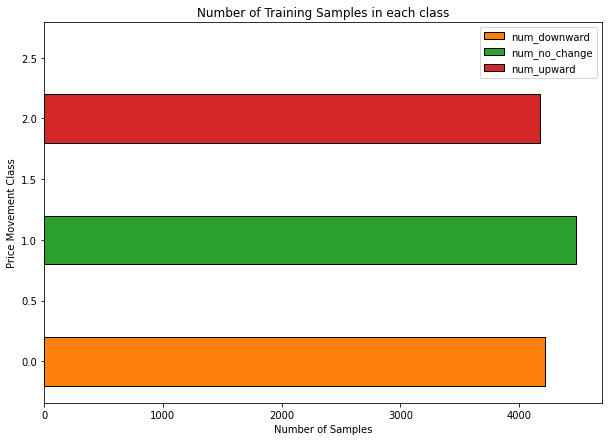

In [17]:
fig = plt.figure(figsize=(10, 7))
plt.barh([2.25], [0]) # expand to fit the legend
plt.barh([0], [num_downward], height=0.4, edgecolor='k', label='num_downward')
plt.barh([1], [num_no_change], height=0.4, edgecolor='k', label='num_no_change')
plt.barh([2], [num_upward], height=0.4, edgecolor='k', label='num_upward')
plt.title('Number of Training Samples in each class')
plt.xlabel('Number of Samples')
plt.ylabel('Price Movement Class')
plt.legend();

### Observe the data statistics

Note that this is across 4 correlated stocks

In [18]:
train_df.describe()

,Open,High,Low,Close,Volume,price_diff,price_change
count,33248.000000,33248.000000,33248.000000,33248.000000,3.324800e+04,33248.000000,33248.000000
mean,163.974449,164.422785,163.512864,163.973821,1.864543e+06,0.010190,1.002466
std,62.598593,62.960503,62.221521,62.595739,2.213236e+06,1.016718,0.530417
min,76.118000,76.316500,75.731000,75.826000,3.846000e+04,-29.973333,0.000000
25%,127.745991,128.020639,127.481716,127.744404,3.703200e+05,-0.224657,1.000000
50%,141.915051,142.141720,141.649502,141.894783,1.180156e+06,0.004859,1.000000
75%,180.102819,180.629048,179.684275,180.116793,2.533532e+06,0.232112,1.000000
max,413.166633,414.496667,412.700000,413.056667,5.643245e+07,36.012633,2.000000


We can see that the price data,price diff and the Volumn are extremely different. It may be useful to experiment by taking the log of the volume and price, and maybe even upscaling the proce diff to get them in the same numeric neighborhood. Then we could standardize them with the training mean and Standard Deviation.

Now let's plot the data. We will opt not to plot the Volume, since it makes the prices plots alomost useless. The volume is a clear time series outlier, but we opt to leave it in the data since it is a useful indicator of price movements.

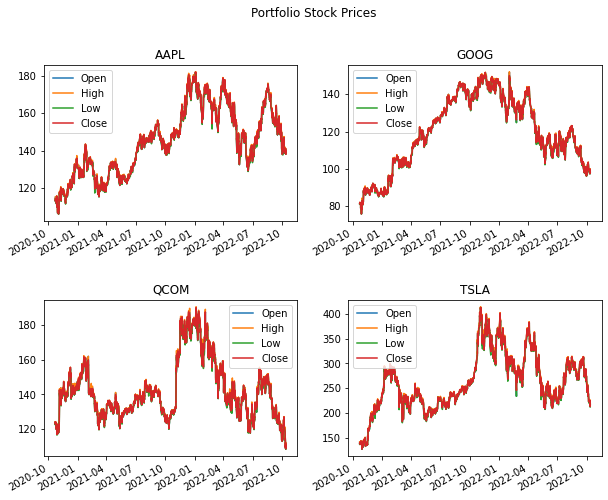

In [78]:
%matplotlib inline

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

stock_dfs['AAPL'][['Open', 'High', 'Low', 'Close']].plot(ax=ax[0, 0])
stock_dfs['GOOG'][['Open', 'High', 'Low', 'Close']].plot(ax=ax[0, 1])
stock_dfs['QCOM'][['Open', 'High', 'Low', 'Close']].plot(ax=ax[1, 0])
stock_dfs['TSLA'][['Open', 'High', 'Low', 'Close']].plot(ax=ax[1, 1]);

ax[0, 0].set_title('AAPL')
ax[0, 1].set_title('GOOG')
ax[1, 0].set_title('QCOM')
ax[1, 1].set_title('TSLA');

# ax[0, 0].set_ylim(50, 500)
# ax[0, 1].set_ylim(50, 500)
# ax[1, 0].set_ylim(50, 500)
# ax[1, 1].set_ylim(50, 500);

fig.suptitle('Portfolio Stock Prices');

fig.subplots_adjust(hspace=0.5);

In [72]:
aapl_close_diff = stock_dfs['AAPL']['Close'].diff()
goog_close_diff = stock_dfs['GOOG']['Close'].diff()
qcom_close_diff = stock_dfs['QCOM']['Close'].diff()
tsla_close_diff = stock_dfs['TSLA']['Close'].diff()

In [73]:
# use IQR to detect price change outliers

def get_iqr(ser):
    q1 = ser.quantile(0.25)
    q3 = ser.quantile(0.75)
    iqr = q3 - q1

    return q1, q3, iqr

q1, q3, iqr = get_iqr(aapl_close_diff)
print(iqr)
print(q1 - iqr)
print(q3 + iqr)

print(q1 - 0.75*iqr)
print(q3 + 0.75*iqr)

0.41425187500002636
-0.6193740000000361
0.623381625000043
-0.5158110312500295
0.5198186562500364


In [74]:
tsla_close_diff[(tsla_close_diff <= (q1 - 1.*iqr)) | (tsla_close_diff >= (q3 + 1.*iqr))]

2020-10-23 11:15:00    0.809433
2020-10-23 12:45:00    0.981700
2020-10-23 13:30:00   -0.643333
2020-10-23 16:00:00    0.965000
2020-10-26 09:45:00   -1.838333
                         ...   
2022-10-12 13:30:00   -0.780000
2022-10-12 14:00:00    0.701700
2022-10-12 14:15:00    0.998300
2022-10-12 14:30:00    1.350000
2022-10-12 14:45:00   -0.716000
Name: Close, Length: 6983, dtype: float64

In [81]:
aapl_close_diff = get_numeric_price_trend(stock_dfs['AAPL'])['price_trend']
goog_close_diff = get_numeric_price_trend(stock_dfs['GOOG'])['price_trend']
qcom_close_diff = get_numeric_price_trend(stock_dfs['QCOM'])['price_trend']
tsla_close_diff = get_numeric_price_trend(stock_dfs['TSLA'])['price_trend']

C:\Users\itber\AppData\Local\Temp\ipykernel_35328\740664823.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_trend'] = price_trend - df[['Open', 'Close']].mean(axis=1)
C:\Users\itber\AppData\Local\Temp\ipykernel_35328\740664823.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_trend'] = price_trend - df[['Open', 'Close']].mean(axis=1)
C:\Users\itber\AppData\Local\Temp\ipykernel_35328\740664823.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

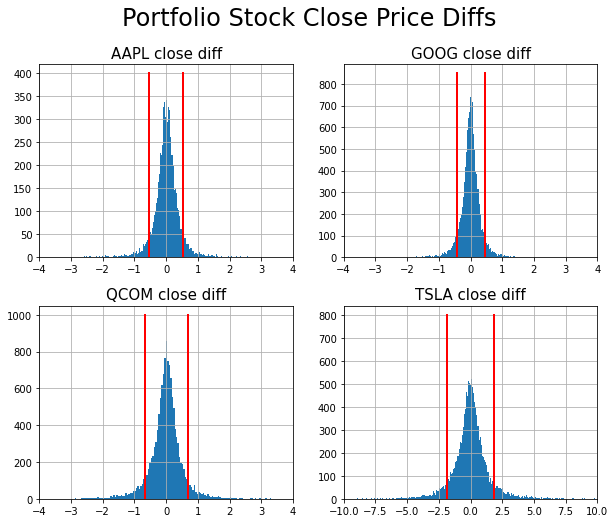

In [82]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

aapl_close_diff.hist(ax=ax[0, 0], bins=500) # .plot(ax=ax[0, 0])
goog_close_diff.hist(ax=ax[0, 1], bins=500) # .plot(ax=ax[0, 1])
qcom_close_diff.hist(ax=ax[1, 0], bins=500) # .plot(ax=ax[1, 0])
tsla_close_diff.hist(ax=ax[1, 1], bins=500) # .plot(ax=ax[1, 1]);

# IQR qeighting
iqr_w = 1

# plot IQR lines
q1, q3, iqr = get_iqr(aapl_close_diff)
ax[0, 0].plot([q1 - iqr_w*iqr, q1 - iqr_w*iqr], [0, 400], color='r', linewidth=2)
ax[0, 0].plot([q3 + iqr_w*iqr, q3 + iqr_w*iqr], [0, 400], color='r', linewidth=2)

q1, q3, iqr = get_iqr(goog_close_diff)
ax[0, 1].plot([q1 - iqr_w*iqr, q1 - iqr_w*iqr], [0, 850], color='r', linewidth=2)
ax[0, 1].plot([q3 + iqr_w*iqr, q3 + iqr_w*iqr], [0, 850], color='r', linewidth=2)

q1, q3, iqr = get_iqr(qcom_close_diff)
ax[1, 0].plot([q1 - iqr_w*iqr, q1 - iqr_w*iqr], [0, 1000], color='r', linewidth=2)
ax[1, 0].plot([q3 + iqr_w*iqr, q3 + iqr_w*iqr], [0, 1000], color='r', linewidth=2)

q1, q3, iqr = get_iqr(tsla_close_diff)
ax[1, 1].plot([q1 - iqr_w*iqr, q1 - iqr_w*iqr], [0, 800], color='r', linewidth=2)
ax[1, 1].plot([q3 + iqr_w*iqr, q3 + iqr_w*iqr], [0, 800], color='r', linewidth=2)

ax[0, 0].set_title('AAPL close diff', size=15)
ax[0, 1].set_title('GOOG close diff', size=15)
ax[1, 0].set_title('QCOM close diff', size=15)
ax[1, 1].set_title('TSLA close diff', size=15);

# ax[0, 0].set_ylim(50, 500)
# ax[0, 1].set_ylim(50, 500)
# ax[1, 0].set_ylim(50, 500)
# ax[1, 1].set_ylim(50, 500);

ax[0, 0].set_xlim(-4, 4)
ax[0, 1].set_xlim(-4, 4)
ax[1, 0].set_xlim(-4, 4)
ax[1, 1].set_xlim(-10, 10);


fig.suptitle('Portfolio Stock Close Price Diffs', size=24);

fig.subplots_adjust(hspace=0.25);

Now plot trading volume for each stock

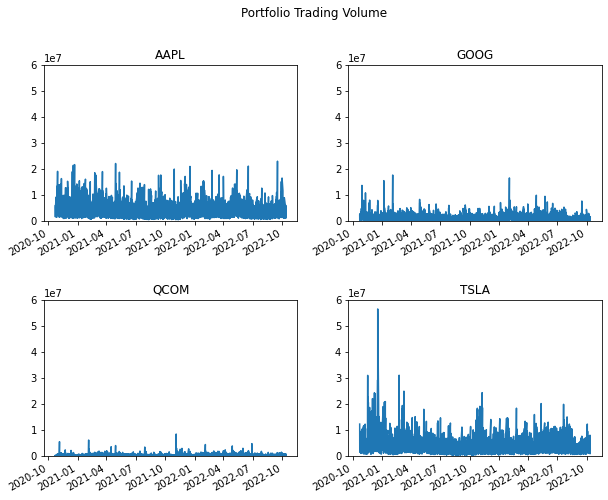

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

stock_dfs['AAPL']['Volume'].plot(ax=ax[0, 0])
stock_dfs['GOOG']['Volume'].plot(ax=ax[0, 1])
stock_dfs['QCOM']['Volume'].plot(ax=ax[1, 0])
stock_dfs['TSLA']['Volume'].plot(ax=ax[1, 1]);

ax[0, 0].set_title('AAPL')
ax[0, 1].set_title('GOOG')
ax[1, 0].set_title('QCOM')
ax[1, 1].set_title('TSLA');

ax[0, 0].set_ylim(0, 6e7)
ax[0, 1].set_ylim(0, 6e7)
ax[1, 0].set_ylim(0, 6e7)
ax[1, 1].set_ylim(0, 6e7);

fig.suptitle('Portfolio Trading Volume');

fig.subplots_adjust(hspace=0.5);

Now plot the log trading volume for each stock

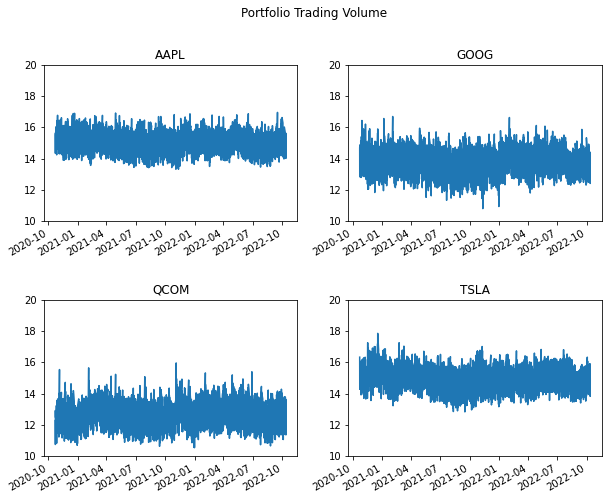

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

np.log(stock_dfs['AAPL']['Volume']).plot(ax=ax[0, 0])
np.log(stock_dfs['GOOG']['Volume']).plot(ax=ax[0, 1])
np.log(stock_dfs['QCOM']['Volume']).plot(ax=ax[1, 0])
np.log(stock_dfs['TSLA']['Volume']).plot(ax=ax[1, 1]);

ax[0, 0].set_title('AAPL')
ax[0, 1].set_title('GOOG')
ax[1, 0].set_title('QCOM')
ax[1, 1].set_title('TSLA');

ax[0, 0].set_ylim(10, 20)
ax[0, 1].set_ylim(10, 20)
ax[1, 0].set_ylim(10, 20)
ax[1, 1].set_ylim(10, 20);

fig.suptitle('Portfolio Trading Volume');

fig.subplots_adjust(hspace=0.5);

Now explore correlations

We can see that the final parts of each stock data looks similar, but the first part of the stocks do not look similar. This is because the data correlation was computed using the most recent 60 days from early October 2022.

### Get Standardized train, valid, and test sets

Split into train, valid, and test sets. And then standardize with training mean and standard deviation

In [8]:
# first we will take the log of the trading volume to place in a similar neighborhood as the prices
train_df['Volume'] = np.log(train_df['Volume'])
valid_df['Volume'] = np.log(valid_df['Volume'])
test_df['Volume'] = np.log(test_df['Volume'])

train_mean = train_df.mean()
train_std = train_df.std()

# ensure that target column is not standardized
train_mean.price_change = 0
train_std.price_change = 1

train_df = (train_df - train_mean) / train_std
valid_df = (valid_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(33248, 7)
(10816, 7)
(7488, 7)


## Start Training Models

We will train a few base models and compare their results on validation data
- Neural Network
- Transformer
- LSTM

For the training we will keep the mutual hyperparameters the same and we will implement early stopping
- batch size = 32
- epochs = 10
- learning rate = 1e-4
- early stopping patience = 2

First we will obtain a baseline predictor which will use the previous class as it's next prediction. This will provide a good indicator if our models are being trained effectively

In [9]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

Obtain windowed data for a single step, this will be used for the baseline model and the neural network since it doesn't model sequential data.

In [12]:
single_step_window_baseline = WindowGenerator(
        input_width=1, label_width=1, shift=1,
        train_df=train_df, valid_df=valid_df, test_df=test_df,
        remove_labels_from_inputs=False, batch_size=32, 
        shuffle=True, seed=42, label_columns=['price_change'])

single_step_window = WindowGenerator(
        input_width=1, label_width=1, shift=1,
        train_df=train_df, valid_df=valid_df, test_df=test_df,
        remove_labels_from_inputs=True, batch_size=32, 
        shuffle=True, seed=42, label_columns=['price_change'])

In [12]:
baseline = Baseline(label_index=single_step_window_baseline.column_indices['price_change'])

baseline.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

train_performance = {}
val_performance = {}
train_performance['Baseline'] = baseline.evaluate(single_step_window_baseline.train)
val_performance['Baseline'] = baseline.evaluate(single_step_window_baseline.valid)

338/338 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.5300


For the other models we will make a function to make the training process easier

In [9]:
def compile_and_fit(model, window, lr=1e-4, max_epochs=100, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['accuracy'])

    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.valid,
                        callbacks=[early_stopping])
    return history

### Train the Neural Network

First we will train a linear classifier, then we will train a Neural Network with more layers

In [14]:
linear = tf.keras.Sequential([
    layers.Dense(units=3, activation='softmax')
])

In [15]:
history = compile_and_fit(linear, single_step_window, patience=2, max_epochs=10)


train_performance['linear'] = linear.evaluate(single_step_window.train)
val_performance['linear'] = linear.evaluate(single_step_window.valid)

Epoch 1/10
1039/1039 [==============================] - 10s 7ms/step - loss: 2.1379 - accuracy: 0.1697 - val_loss: 1.8658 - val_accuracy: 0.2423
Epoch 2/10
1039/1039 [==============================] - 7s 6ms/step - loss: 1.6511 - accuracy: 0.1806 - val_loss: 1.4719 - val_accuracy: 0.2692
Epoch 3/10
1039/1039 [==============================] - 7s 6ms/step - loss: 1.2643 - accuracy: 0.2712 - val_loss: 1.1944 - val_accuracy: 0.4206
Epoch 4/10
1039/1039 [==============================] - 7s 6ms/step - loss: 1.0092 - accuracy: 0.5533 - val_loss: 1.0494 - val_accuracy: 0.5479
Epoch 5/10
  52/1039 [>.............................] - ETA: 5s - loss: 0.9420 - accuracy: 0.6581

In [94]:
dense = tf.keras.Sequential([
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=3, activation='softmax')
])

In [95]:
history = compile_and_fit(dense, single_step_window, patience=2, max_epochs=10)

train_performance['Dense'] = dense.evaluate(single_step_window.train)
val_performance['Dense'] = dense.evaluate(single_step_window.valid)

Epoch 1/10
1039/1039 [==============================] - 7s 6ms/step - loss: 0.7804 - accuracy: 0.6883 - val_loss: 0.9816 - val_accuracy: 0.5883
Epoch 2/10
1039/1039 [==============================] - 6s 6ms/step - loss: 0.6810 - accuracy: 0.7313 - val_loss: 0.9712 - val_accuracy: 0.5859
Epoch 3/10
1039/1039 [==============================] - 6s 6ms/step - loss: 0.6715 - accuracy: 0.7334 - val_loss: 0.9624 - val_accuracy: 0.5855
Epoch 4/10
1039/1039 [==============================] - 6s 6ms/step - loss: 0.6658 - accuracy: 0.7342 - val_loss: 0.9584 - val_accuracy: 0.5858
Epoch 5/10
1039/1039 [==============================] - 6s 6ms/step - loss: 0.6623 - accuracy: 0.7341 - val_loss: 0.9560 - val_accuracy: 0.5848
Epoch 6/10
1039/1039 [==============================] - 6s 6ms/step - loss: 0.6601 - accuracy: 0.7329 - val_loss: 0.9557 - val_accuracy: 0.5846
Epoch 7/10
1039/1039 [==============================] - 6s 6ms/step - loss: 0.6584 - accuracy: 0.7335 - val_loss: 0.9547 - val_accuracy:

### Get Data Generator for each time step

This data generator will be used for our models that handle sequential data such as the Transformer and LSTM

In [10]:
data_gen = WindowGenerator(
                input_width=32, label_width=1, shift=1, 
                train_df=train_df, valid_df=valid_df, test_df=test_df,
                remove_labels_from_inputs=True, batch_size=32, 
                shuffle=True, seed=42, label_columns=['price_change'])

###  Build and Train the Transformer Encoder

In [14]:
transformer_model = TransformerModel(
            n_heads=2,
            d_model=512,
            ff_dim=256,
            num_transformer_blocks=2,
            mlp_units=[256],
            n_outputs=3,
            dropout=0.1,
            mlp_dropout=0.1)

# transformer_model = Transformer(
#         num_layers=2,
#         d_model=512,
#         num_heads=2,
#         dff=256,
#         num_outputs=3,
#         dropout_rate=0.1)

In [15]:
compile_and_fit(transformer_model, data_gen, lr=1e-4,
                patience=2, max_epochs=2)

train_performance['transformer'] = transformer_model.evaluate(data_gen.train)
val_performance['transformer'] = transformer_model.evaluate(data_gen.valid)

Epoch 1/2
  86/1038 [=>............................] - ETA: 57s - loss: 0.8538 - accuracy: 0.6628

KeyboardInterrupt: 

### Build and Train the LSTM

In [103]:

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    layers.LSTM(25, dropout=0.0, return_sequences=True),
    layers.LSTM(25, dropout=0.0, return_sequences=True),
    layers.LSTM(25, dropout=0.0),
    # Shape => [batch, time, features]
    # layers.TimeDistributed(layers.Dense(units=3, activation='softmax')),
    layers.Dense(units=3, activation='softmax'),
    layers.Reshape([1, -1])
])

In [107]:
compile_and_fit(lstm_model, data_gen, lr=1e-4,
                patience=2, max_epochs=10)

train_performance['lstm'] = lstm_model.evaluate(data_gen.train)
val_performance['lstm'] = lstm_model.evaluate(data_gen.valid)

Epoch 1/10
1038/1038 [==============================] - 22s 19ms/step - loss: 0.6523 - accuracy: 0.7320 - val_loss: 0.9122 - val_accuracy: 0.5873
Epoch 2/10
1038/1038 [==============================] - 18s 18ms/step - loss: 0.6507 - accuracy: 0.7326 - val_loss: 0.9048 - val_accuracy: 0.5873
Epoch 3/10
1038/1038 [==============================] - 18s 18ms/step - loss: 0.6493 - accuracy: 0.7331 - val_loss: 0.9150 - val_accuracy: 0.5880
Epoch 4/10
337/337 [==============================] - 3s 9ms/step - loss: 0.9078 - accuracy: 0.5884


In [108]:
val_performance

{'Baseline': [nan, 0.530004620552063],
 'linear': [0.944926917552948, 0.5886269211769104],
 'Dense': [0.9514778852462769, 0.5853906869888306],
 'transformer': [0.8943844437599182, 0.592915415763855],
 'lstm': [0.9077631235122681, 0.5883716344833374]}

In [109]:
train_performance

{'Baseline': [nan, 0.6891449093818665],
 'linear': [0.689243495464325, 0.7276145219802856],
 'Dense': [0.654122531414032, 0.7343820333480835],
 'transformer': [0.6135666370391846, 0.7397639751434326],
 'lstm': [0.6472254991531372, 0.7328696846961975]}

## Observations

It has been observed thar when using only price and trading volume data that the Lienar Classifier and Neural Network generally perform better than the Transformer and LSTM. It is unclear why this happens, perhaps the data being fed into the models is insufficient for this modeling purpose. 

However, When we add the price difference as an additional feature we observe that the Transformer and LSTM models outperform the Linear Classifier and Neural Network. This could be due to the fact the price change is directly related to the target variable that we are trying to model (i.e. it can be thought of as a continuous version of our target variable). Prehaps the models are able to characterize the sequence of price changes and relate them to the prices and volume data and in turn learn a better understanding of the future price movement.